In [1]:
# Fix randomness and hide warnings
seed = 42
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rc('font', size=16)

from C2.notebooks.Utils import split_dataset, build_sequences_optimized
from C2.notebooks.data_augmentation import augment_data

2.15.0


In [2]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')

In [3]:

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_validation_data, train_validation_labels, test_data, test_labels = split_dataset(dataset, labels)
train_data, train_labels, validation_data, validation_labels = split_dataset(train_validation_data, train_validation_labels, augment_train_data=True, num_augmentations=3)

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
train_data.shape

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]

Dataset shape:  (48000, 200)
Train data shape:  (38400, 200)
Test data shape:  (9600, 200)
Augmenting training data
Augmentation round: 0
Augmentation round: 1
Augmentation round: 2
Train data shape:  (276480, 200)
Test data shape:  (7680, 200)


In [23]:
def build_LSTM_ENC_RESIDUAL(input_shape, output_shape, learning_rate=0.001, num_layers=2, num_units_lstm=32, num_units_final_dense = 128, dropout=0.2, last_activation='relu'):
    assert input_shape[0] >= output_shape[0], "Input time steps should be >= output time steps"

    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')

    # LSTM layers
    x = input_layer
    for _ in range(num_layers):
        # Make residual connection
        residual = x
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units_lstm, name='lstm', return_sequences=True))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Dense(input_shape[0], activation='relu')(x)
        x = tf.keras.layers.Add()([x, residual])
        # x = tf.keras.layers.Concatenate()([x, input_layer])
        
        
        
    x = tf.keras.layers.Flatten()(x)
    flatten_input = tf.keras.layers.Flatten()(input_layer)
    # Skip-connetion with input
    x = tf.keras.layers.Concatenate()([x, flatten_input])
    
    # Dense layers
    x = tf.keras.layers.Dense(num_units_final_dense, activation='relu')(x)
    # Output layer
    output_layer = tf.keras.layers.Dense(output_shape[0], name='output_layer', activation=last_activation, kernel_initializer=tf.initializers.zeros())(x)
    # Model instantiation
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='LSTM_ENC_RESIDUAL')

    # Compiling the model
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model
    


## Optuna optimization

In [24]:
import optuna as opt
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial):
    # Clear clutter from previous session graphs.
    tf.keras.backend.clear_session()

    # Hyperparameters to be tuned by Optuna.
    trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    trial.suggest_int("num_layers", 0, 1)
    trial.suggest_int("num_units_lstm", 16, 128, log=True)
    trial.suggest_int("num_units_final_dense", 16, 128, log=True)
    trial.suggest_float("dropout", 0.0, 0.5)
    trial.suggest_categorical("last_activation", ['tanh', 'sigmoid'])
    
    
    batch_size = 256
    epochs = 30

    # Build the model.
    model = build_LSTM_ENC_RESIDUAL(input_shape, output_shape, **trial.params)

    # Train the model.
    model.fit(
        x = train_data,
        y = train_labels,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(validation_data, validation_labels),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5),
            TFKerasPruningCallback(trial, "val_loss"),
        ]
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(validation_data, validation_labels, verbose=0)
    return score[0]

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]

# create a study object and optimize the objective function.
study = opt.create_study(direction="minimize", pruner=MedianPruner(n_warmup_steps=1), sampler=TPESampler(seed=seed), study_name='build_LSTM_ENC_RESIDUAL', storage='sqlite:///../data/optuna.db', load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2023-12-16 20:44:10,418] A new study created in RDB with name: build_LSTM_ENC_RESIDUAL


Epoch 1/30
1080/1080 [==============================] - 68s 60ms/step - loss: 0.0290 - mean_absolute_error: 0.1249 - val_loss: 0.0297 - val_mean_absolute_error: 0.1238 - lr: 3.1489e-04
Epoch 2/30
1080/1080 [==============================] - 65s 60ms/step - loss: 0.0200 - mean_absolute_error: 0.1036 - val_loss: 0.0278 - val_mean_absolute_error: 0.1177 - lr: 3.1489e-04
Epoch 3/30
1080/1080 [==============================] - 64s 59ms/step - loss: 0.0187 - mean_absolute_error: 0.0999 - val_loss: 0.0275 - val_mean_absolute_error: 0.1168 - lr: 3.1489e-04
Epoch 4/30
1080/1080 [==============================] - 64s 59ms/step - loss: 0.0179 - mean_absolute_error: 0.0975 - val_loss: 0.0263 - val_mean_absolute_error: 0.1143 - lr: 3.1489e-04
Epoch 5/30
1080/1080 [==============================] - 65s 60ms/step - loss: 0.0172 - mean_absolute_error: 0.0957 - val_loss: 0.0270 - val_mean_absolute_error: 0.1154 - lr: 3.1489e-04
Epoch 6/30
1080/1080 [==============================] - 65s 60ms/step - los

[I 2023-12-16 20:51:51,054] Trial 0 finished with value: 0.026308441534638405 and parameters: {'learning_rate': 0.00031489116479568613, 'num_layers': 1, 'num_units_lstm': 73, 'num_units_final_dense': 55, 'dropout': 0.07800932022121826, 'last_activation': 'tanh'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 65s 57ms/step - loss: 0.3354 - mean_absolute_error: 0.5039 - val_loss: 0.2943 - val_mean_absolute_error: 0.4680 - lr: 0.0292
Epoch 2/30
1080/1080 [==============================] - 60s 56ms/step - loss: 0.3356 - mean_absolute_error: 0.5041 - val_loss: 0.2943 - val_mean_absolute_error: 0.4680 - lr: 0.0292
Epoch 3/30
1080/1080 [==============================] - 61s 56ms/step - loss: 0.3356 - mean_absolute_error: 0.5041 - val_loss: 0.2943 - val_mean_absolute_error: 0.4680 - lr: 0.0292
Epoch 4/30
1080/1080 [==============================] - 61s 56ms/step - loss: 0.3356 - mean_absolute_error: 0.5041 - val_loss: 0.2943 - val_mean_absolute_error: 0.4680 - lr: 0.0029


[I 2023-12-16 20:56:02,956] Trial 1 finished with value: 0.29433003067970276 and parameters: {'learning_rate': 0.029154431891537533, 'num_layers': 1, 'num_units_lstm': 69, 'num_units_final_dense': 16, 'dropout': 0.48495492608099716, 'last_activation': 'tanh'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0565 - mean_absolute_error: 0.1930 - val_loss: 0.0541 - val_mean_absolute_error: 0.1854 - lr: 5.3370e-05
Epoch 2/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0436 - mean_absolute_error: 0.1657 - val_loss: 0.0455 - val_mean_absolute_error: 0.1691 - lr: 5.3370e-05
Epoch 3/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0381 - mean_absolute_error: 0.1530 - val_loss: 0.0397 - val_mean_absolute_error: 0.1560 - lr: 5.3370e-05
Epoch 4/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0343 - mean_absolute_error: 0.1435 - val_loss: 0.0363 - val_mean_absolute_error: 0.1466 - lr: 5.3370e-05
Epoch 5/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0314 - mean_absolute_error: 0.1358 - val_loss: 0.0335 - val_mean_absolute_error: 0.1383 - lr: 5.3370e-05
Epoch 6/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0296 - 

[I 2023-12-16 20:56:43,140] Trial 2 finished with value: 0.02904050424695015 and parameters: {'learning_rate': 5.3370327626039544e-05, 'num_layers': 0, 'num_units_lstm': 29, 'num_units_final_dense': 47, 'dropout': 0.21597250932105788, 'last_activation': 'sigmoid'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0612 - mean_absolute_error: 0.2031 - val_loss: 0.0572 - val_mean_absolute_error: 0.1916 - lr: 3.6139e-05
Epoch 2/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0482 - mean_absolute_error: 0.1755 - val_loss: 0.0503 - val_mean_absolute_error: 0.1786 - lr: 3.6139e-05
Epoch 3/30
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0426 - mean_absolute_error: 0.1638 - val_loss: 0.0447 - val_mean_absolute_error: 0.1674 - lr: 3.6139e-05
Epoch 4/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0388 - mean_absolute_error: 0.1549 - val_loss: 0.0417 - val_mean_absolute_error: 0.1602 - lr: 3.6139e-05
Epoch 5/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0360 - mean_absolute_error: 0.1480 - val_loss: 0.0391 - val_mean_absolute_error: 0.1536 - lr: 3.6139e-05
Epoch 6/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0336 - 

[I 2023-12-16 20:57:41,911] Trial 3 finished with value: 0.030050307512283325 and parameters: {'learning_rate': 3.613894271216525e-05, 'num_layers': 0, 'num_units_lstm': 34, 'num_units_final_dense': 41, 'dropout': 0.3925879806965068, 'last_activation': 'sigmoid'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0312 - mean_absolute_error: 0.1330 - val_loss: 0.0296 - val_mean_absolute_error: 0.1245 - lr: 0.0023
Epoch 2/30
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0236 - mean_absolute_error: 0.1138 - val_loss: 0.0300 - val_mean_absolute_error: 0.1226 - lr: 0.0023
Epoch 3/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0224 - mean_absolute_error: 0.1104 - val_loss: 0.0297 - val_mean_absolute_error: 0.1220 - lr: 0.0023
Epoch 4/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0214 - mean_absolute_error: 0.1073 - val_loss: 0.0299 - val_mean_absolute_error: 0.1222 - lr: 2.3424e-04


[I 2023-12-16 20:57:55,473] Trial 4 finished with value: 0.029583962634205818 and parameters: {'learning_rate': 0.00234238498471129, 'num_layers': 0, 'num_units_lstm': 56, 'num_units_final_dense': 22, 'dropout': 0.03252579649263976, 'last_activation': 'sigmoid'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0290 - mean_absolute_error: 0.1273 - val_loss: 0.0298 - val_mean_absolute_error: 0.1264 - lr: 0.0171
Epoch 2/30
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0229 - mean_absolute_error: 0.1121 - val_loss: 0.0314 - val_mean_absolute_error: 0.1277 - lr: 0.0171
Epoch 3/30
1080/1080 [==============================] - 3s 3ms/step - loss: 0.0221 - mean_absolute_error: 0.1099 - val_loss: 0.0299 - val_mean_absolute_error: 0.1233 - lr: 0.0171
Epoch 4/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.1033 - val_loss: 0.0285 - val_mean_absolute_error: 0.1194 - lr: 0.0017
Epoch 5/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.1028 - val_loss: 0.0288 - val_mean_absolute_error: 0.1207 - lr: 0.0017
Epoch 6/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0196 - mean_absolute_error:

[I 2023-12-16 20:58:29,901] Trial 5 finished with value: 0.028177479282021523 and parameters: {'learning_rate': 0.01712337597316398, 'num_layers': 0, 'num_units_lstm': 19, 'num_units_final_dense': 66, 'dropout': 0.22007624686980065, 'last_activation': 'sigmoid'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 40s 33ms/step - loss: 0.0419 - mean_absolute_error: 0.1585 - val_loss: 0.0336 - val_mean_absolute_error: 0.1374 - lr: 1.3726e-05
Epoch 2/30
1080/1080 [==============================] - 35s 33ms/step - loss: 0.0313 - mean_absolute_error: 0.1328 - val_loss: 0.0344 - val_mean_absolute_error: 0.1370 - lr: 1.3726e-05
Epoch 3/30
1080/1080 [==============================] - 36s 33ms/step - loss: 0.0294 - mean_absolute_error: 0.1282 - val_loss: 0.0317 - val_mean_absolute_error: 0.1303 - lr: 1.3726e-05
Epoch 4/30
1080/1080 [==============================] - 35s 33ms/step - loss: 0.0279 - mean_absolute_error: 0.1244 - val_loss: 0.0319 - val_mean_absolute_error: 0.1299 - lr: 1.3726e-05
Epoch 5/30
1079/1080 [============================>.] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.1203

[I 2023-12-16 21:01:34,444] Trial 6 pruned. Trial was pruned at epoch 4.


Epoch 1/30
1080/1080 [==============================] - 75s 66ms/step - loss: 0.0326 - mean_absolute_error: 0.1361 - val_loss: 0.0333 - val_mean_absolute_error: 0.1328 - lr: 5.4880e-05
Epoch 2/30
1080/1080 [==============================] - 68s 63ms/step - loss: 0.0234 - mean_absolute_error: 0.1134 - val_loss: 0.0296 - val_mean_absolute_error: 0.1237 - lr: 5.4880e-05
Epoch 3/30
1080/1080 [==============================] - 68s 63ms/step - loss: 0.0209 - mean_absolute_error: 0.1065 - val_loss: 0.0281 - val_mean_absolute_error: 0.1195 - lr: 5.4880e-05
Epoch 4/30
1080/1080 [==============================] - 70s 65ms/step - loss: 0.0195 - mean_absolute_error: 0.1025 - val_loss: 0.0274 - val_mean_absolute_error: 0.1177 - lr: 5.4880e-05
Epoch 5/30
1080/1080 [==============================] - 70s 65ms/step - loss: 0.0189 - mean_absolute_error: 0.1006 - val_loss: 0.0271 - val_mean_absolute_error: 0.1164 - lr: 5.4880e-05
Epoch 6/30
1080/1080 [==============================] - 67s 62ms/step - los

[I 2023-12-16 21:16:40,702] Trial 7 finished with value: 0.026503145694732666 and parameters: {'learning_rate': 5.4880470007660426e-05, 'num_layers': 1, 'num_units_lstm': 80, 'num_units_final_dense': 113, 'dropout': 0.4474136752138244, 'last_activation': 'sigmoid'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0683 - mean_absolute_error: 0.2184 - val_loss: 0.0587 - val_mean_absolute_error: 0.1965 - lr: 2.2593e-05
Epoch 2/30
1080/1080 [==============================] - ETA: 0s - loss: 0.0521 - mean_absolute_error: 0.1835

[I 2023-12-16 21:16:47,298] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/30
1080/1080 [==============================] - 3s 2ms/step - loss: 0.0461 - mean_absolute_error: 0.1702 - val_loss: 0.0387 - val_mean_absolute_error: 0.1535 - lr: 2.6731e-04
Epoch 2/30
1058/1080 [============================>.] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.1368

[I 2023-12-16 21:16:53,677] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/30
1080/1080 [==============================] - 96s 86ms/step - loss: 0.0432 - mean_absolute_error: 0.1427 - val_loss: 0.0276 - val_mean_absolute_error: 0.1188 - lr: 8.5601e-04
Epoch 2/30
1080/1080 [==============================] - 92s 85ms/step - loss: 0.0201 - mean_absolute_error: 0.1041 - val_loss: 0.0309 - val_mean_absolute_error: 0.1243 - lr: 8.5601e-04
Epoch 3/30
1080/1080 [==============================] - 92s 85ms/step - loss: 0.0188 - mean_absolute_error: 0.1002 - val_loss: 0.0274 - val_mean_absolute_error: 0.1166 - lr: 8.5601e-04
Epoch 4/30
1080/1080 [==============================] - 92s 85ms/step - loss: 0.0178 - mean_absolute_error: 0.0976 - val_loss: 0.0270 - val_mean_absolute_error: 0.1154 - lr: 8.5601e-04
Epoch 5/30
1080/1080 [==============================] - 92s 85ms/step - loss: 0.0168 - mean_absolute_error: 0.0950 - val_loss: 0.0269 - val_mean_absolute_error: 0.1158 - lr: 8.5601e-04
Epoch 6/30
1080/1080 [==============================] - 92s 86ms/step - los

[I 2023-12-16 21:32:25,389] Trial 10 finished with value: 0.026620876044034958 and parameters: {'learning_rate': 0.0008560089924423596, 'num_layers': 1, 'num_units_lstm': 120, 'num_units_final_dense': 111, 'dropout': 0.007683868664052143, 'last_activation': 'tanh'}. Best is trial 0 with value: 0.026308441534638405.


Epoch 1/30
1080/1080 [==============================] - 79s 70ms/step - loss: 0.0298 - mean_absolute_error: 0.1270 - val_loss: 0.0309 - val_mean_absolute_error: 0.1257 - lr: 1.8433e-04
Epoch 2/30
1080/1080 [==============================] - 76s 70ms/step - loss: 0.0203 - mean_absolute_error: 0.1045 - val_loss: 0.0298 - val_mean_absolute_error: 0.1210 - lr: 1.8433e-04
Epoch 3/30
1080/1080 [==============================] - 78s 72ms/step - loss: 0.0191 - mean_absolute_error: 0.1008 - val_loss: 0.0282 - val_mean_absolute_error: 0.1182 - lr: 1.8433e-04
Epoch 4/30
 821/1080 [=====================>........] - ETA: 18s - loss: 0.0182 - mean_absolute_error: 0.0984

[W 2023-12-16 21:37:18,034] Trial 11 failed with parameters: {'learning_rate': 0.00018432975952240857, 'num_layers': 1, 'num_units_lstm': 85, 'num_units_final_dense': 128, 'dropout': 0.3380497388469563, 'last_activation': 'tanh'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/federico/Documents/projects/rec-sys/RecSys-2023-polimi/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26302/4159364625.py", line 26, in objective
    model.fit(
  File "/home/federico/Documents/projects/rec-sys/RecSys-2023-polimi/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/home/federico/Documents/projects/rec-sys/RecSys-2023-polimi/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/home/fed

In [12]:
study.best_params

{'learning_rate': 0.002555085039485097,
 'num_layers': 2,
 'num_units_lstm': 28,
 'num_units_final_dense': 31,
 'dropout': 0.3218563683119118}

In [19]:

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]
batch_size = 256
epochs = 10

model = build_LSTM_ENC_RESIDUAL(input_shape, output_shape, **study.best_params)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True) 

Model: "Better_CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 64)                   8704      ['input_layer[0][0]']         
 onal)                                                                                            
                                                                                                  
 dropout_6 (Dropout)         (None, 64)                   0         ['bidirectional_6[0][0]']     
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 18, 64)               0         ['dropout

In [20]:
# Train the model
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    # validation_data=(validation_data, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0003, patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/10
1688/1688 [==============================] - 41s 20ms/step - loss: 0.0231 - mean_absolute_error: 0.1097 - lr: 0.0010
Epoch 2/10
1688/1688 [==============================] - 34s 20ms/step - loss: 0.0204 - mean_absolute_error: 0.1019 - lr: 0.0010
Epoch 3/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0196 - mean_absolute_error: 0.0995 - lr: 0.0010
Epoch 4/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0191 - mean_absolute_error: 0.0981 - lr: 0.0010
Epoch 5/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0186 - mean_absolute_error: 0.0967 - lr: 0.0010
Epoch 6/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0182 - mean_absolute_error: 0.0955 - lr: 0.0010
Epoch 7/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0177 - mean_absolute_error: 0.0943 - lr: 0.0010
Epoch 8/10
1688/1688 [==============================] - 35s 21ms/step - loss: 0.0174 - mean_absolute_err

In [18]:
from C2.notebooks import Utils
from importlib import reload
reload(Utils)
test_data_predictions = model.predict(test_data)
Utils.evaluate_model(test_data_predictions, test_labels)

300/300 [==============================] - 4s 7ms/step
MAE: 0.11244506225454622
MSE: 0.026357403430591904
RMSE: 0.16234963329367857


In [ ]:
# Evaluate random samples
Utils.evaluate_model(np.random.rand(*test_data_predictions.shape), test_labels)

In [ ]:
for _ in range(10):
    idx = np.random.randint(0, len(test_data))
    Utils.plot_predictions(test_data, test_data_predictions, test_labels,idx)
    # Utils.plot_predictions(train_data, test_data_predictions, train_labels,idx)

In [16]:
params = {'learning_rate': 0.002555085039485097,
 'num_layers': 2,
 'num_units_lstm': 28,
 'num_units_final_dense': 31,
 'dropout': 0.3218563683119118}

batch_size = 256
epochs = 30

model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape, **params)

history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(validation_data, validation_labels),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0003, patience=4, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
1080/1080 [==============================] - 54s 46ms/step - loss: 0.0254 - mean_absolute_error: 0.1176 - val_loss: 0.0283 - val_mean_absolute_error: 0.1183 - lr: 0.0026
Epoch 2/30
1080/1080 [==============================] - 49s 45ms/step - loss: 0.0198 - mean_absolute_error: 0.1031 - val_loss: 0.0274 - val_mean_absolute_error: 0.1164 - lr: 0.0026
Epoch 3/30
1080/1080 [==============================] - 48s 45ms/step - loss: 0.0186 - mean_absolute_error: 0.0995 - val_loss: 0.0269 - val_mean_absolute_error: 0.1148 - lr: 0.0026
Epoch 4/30
1080/1080 [==============================] - 49s 45ms/step - loss: 0.0177 - mean_absolute_error: 0.0972 - val_loss: 0.0259 - val_mean_absolute_error: 0.1126 - lr: 0.0026
Epoch 5/30
1080/1080 [==============================] - 49s 45ms/step - loss: 0.0170 - mean_absolute_error: 0.0952 - val_loss: 0.0251 - val_mean_absolute_error: 0.1097 - lr: 0.0026
Epoch 6/30
1080/1080 [==============================] - 49s 45ms/step - loss: 0.0164 - mean_abs

KeyboardInterrupt: 

300/300 [==============================] - 3s 9ms/step
MAE: 0.11541001196773845
MSE: 0.025984960803764636
RMSE: 0.16119851365246715


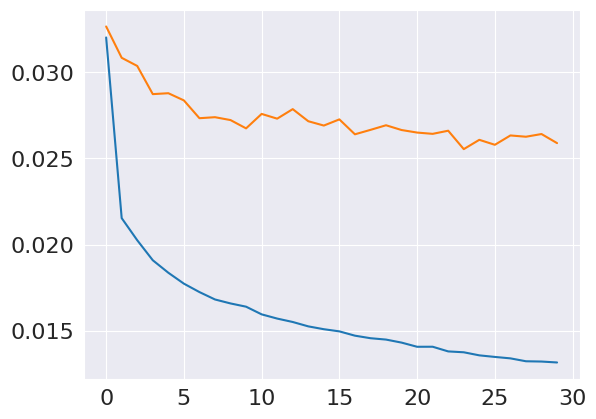

In [13]:
from C2.notebooks import Utils
# plot training history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')

# evaluate the model
test_data_predictions = model.predict(test_data)
Utils.evaluate_model(test_data_predictions, test_labels)

300/300 [==============================] - 5s 10ms/step
MAE: 0.11317666493020336
MSE: 0.026185528589608553
RMSE: 0.16181943205192803


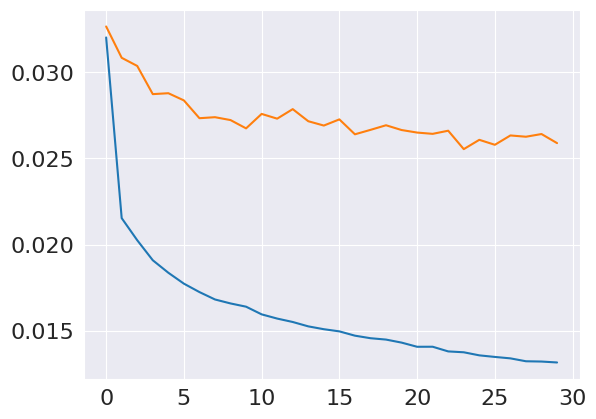

In [17]:
from C2.notebooks import Utils
# plot training history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')

# evaluate the model
test_data_predictions = model.predict(test_data)
Utils.evaluate_model(test_data_predictions, test_labels)

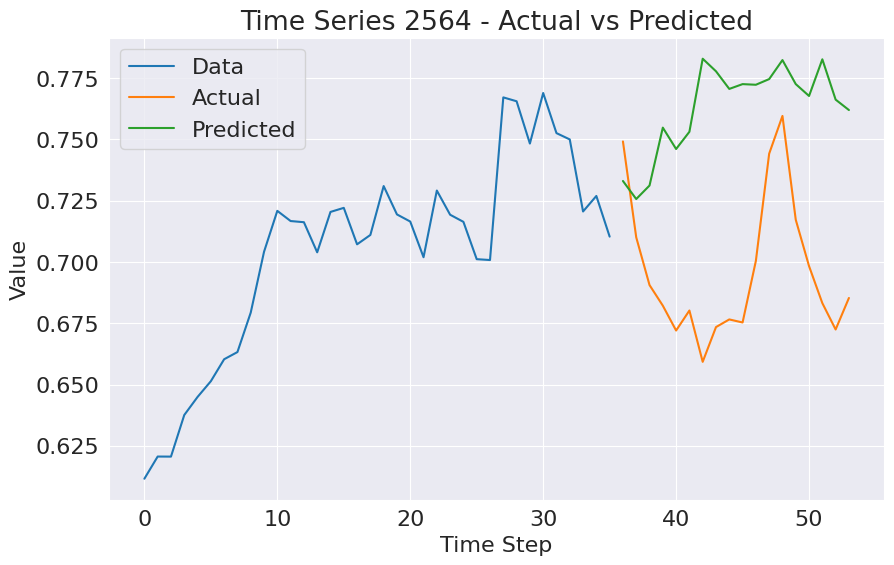

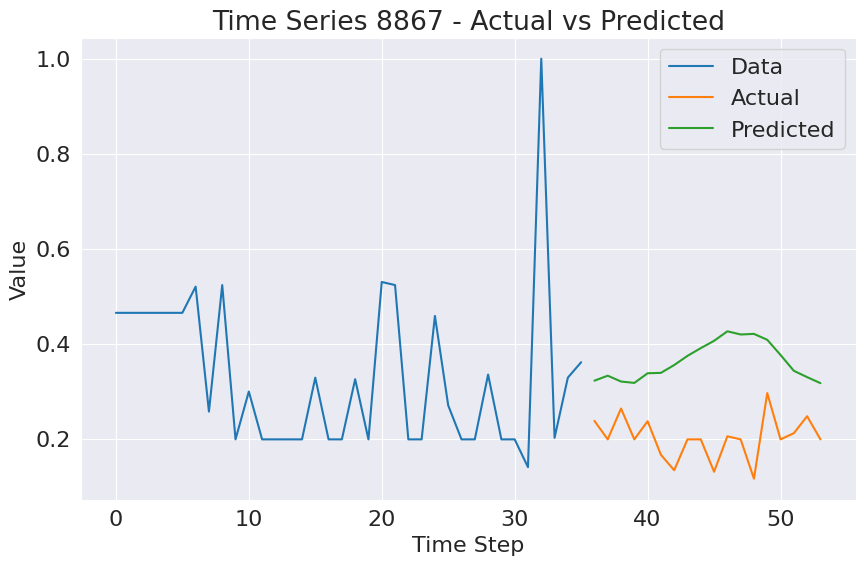

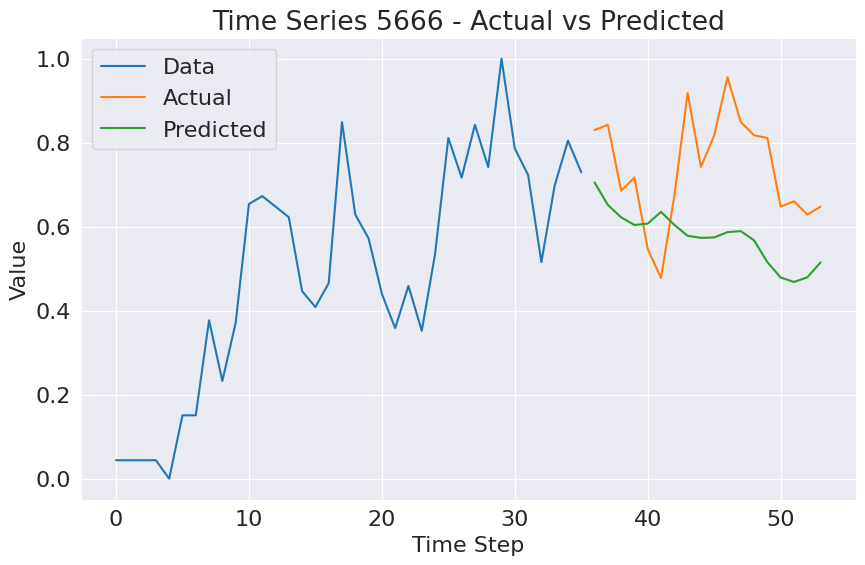

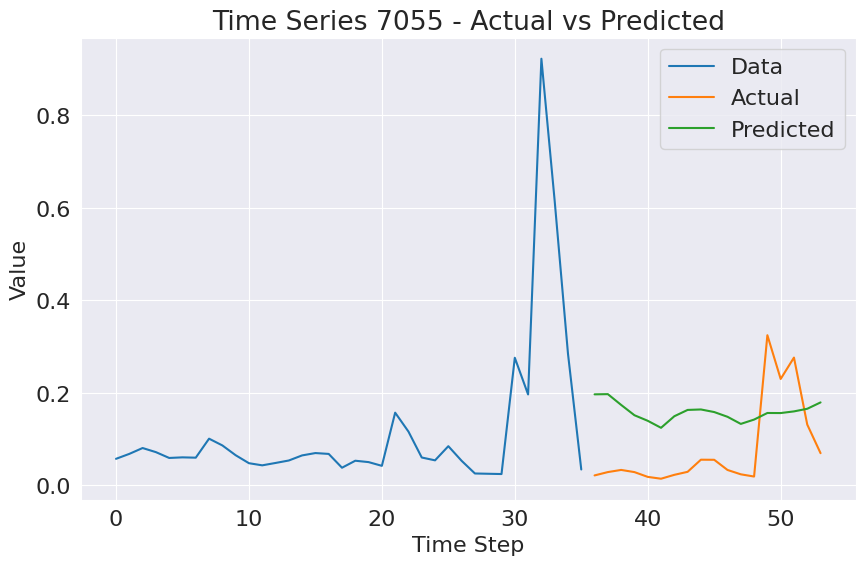

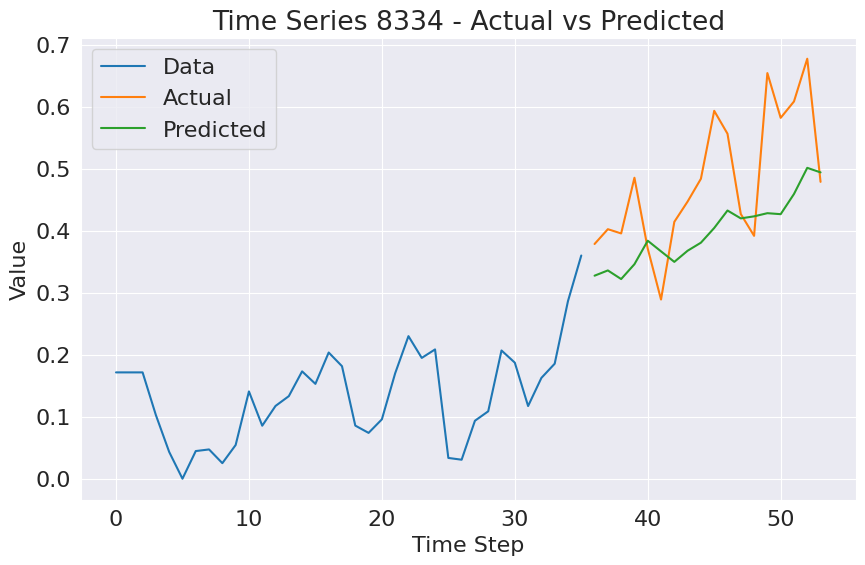

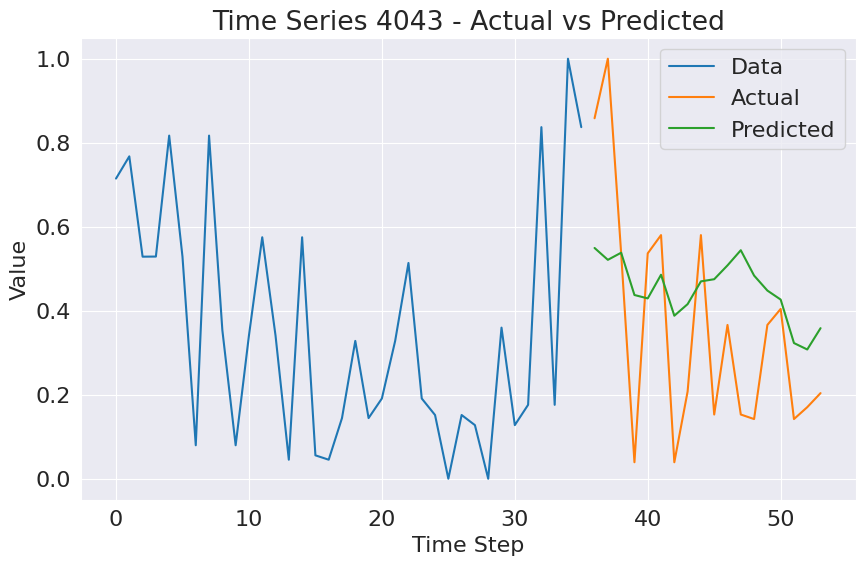

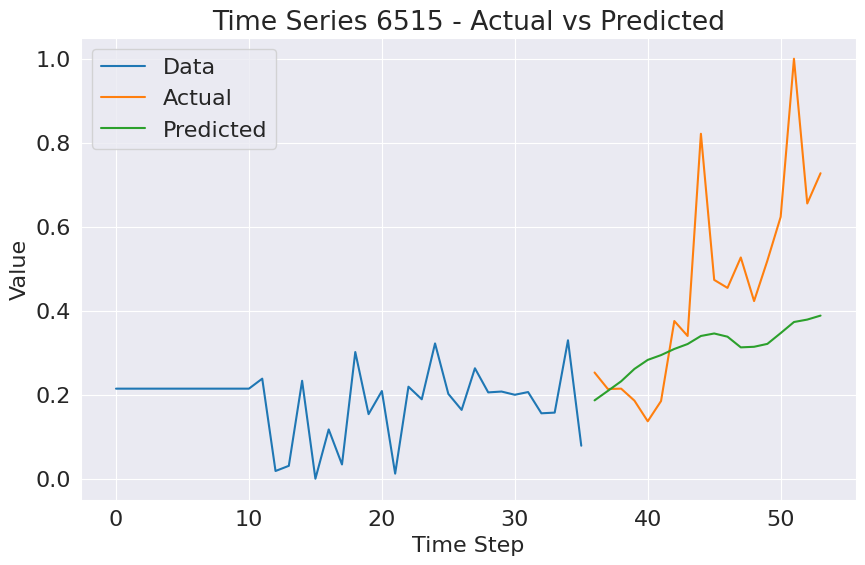

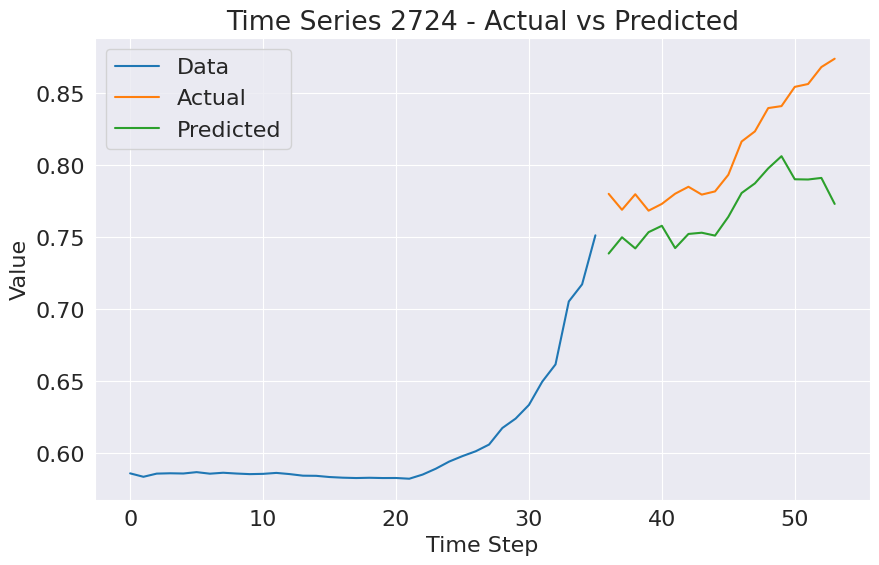

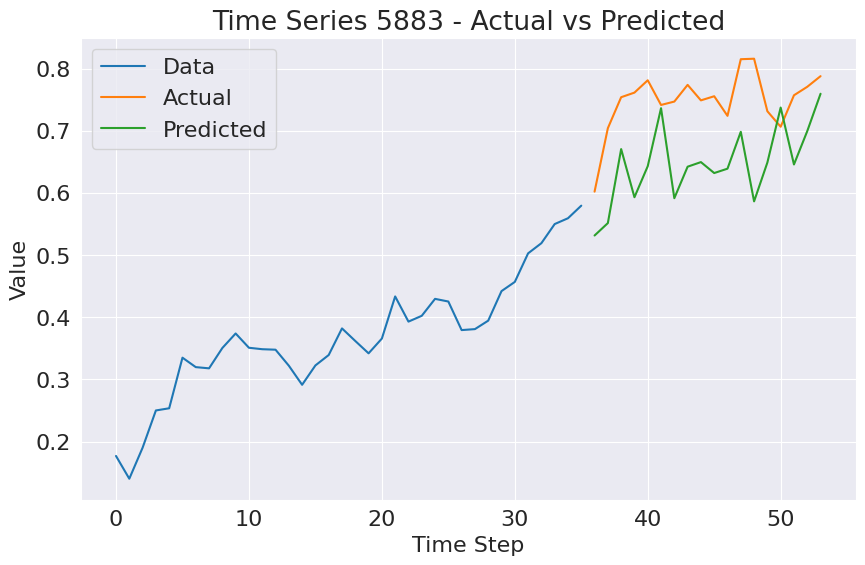

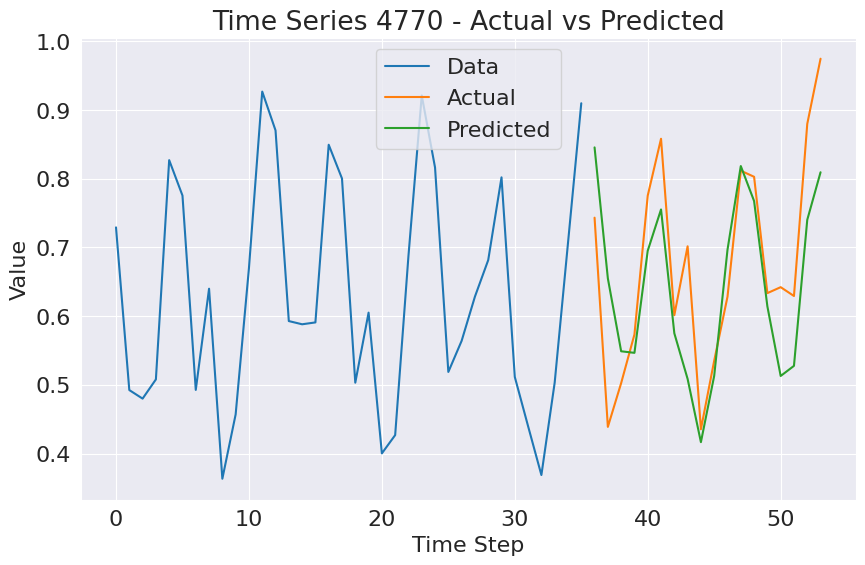

In [18]:
# plot predictions from test
for _ in range(10):
    idx = np.random.randint(0, len(test_data))
    Utils.plot_predictions(test_data, test_data_predictions, test_labels,idx)
    # Utils.plot_predictions(train_data, test_data_predictions, train_labels,idx)

# Retraining for submission

In [3]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')

dataset, labels = build_sequences_optimized(training_data, valid_periods)
train_data, train_labels = augment_data(dataset, labels)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))

input_shape = train_data.shape[1:]
output_shape = train_labels.shape[1:]
batch_size = 256
epochs = 10

params = {'learning_rate': 0.002555085039485097,
 'num_layers': 2,
 'num_units_lstm': 28,
 'num_units_final_dense': 31,
 'dropout': 0.3218563683119118}

model = build_LSTM_ENC_DEC_model_params(input_shape, output_shape, **params)

# Train the model
history = model.fit(
    x = train_data,
    y = train_labels,
    batch_size = batch_size,
    epochs = epochs,
).history

model.save('../data/models/LSTM_ENC_DEC_model_params.h5')

Dataset shape:  (48000, 200)
Augmentation round: 0
Augmentation round: 1
Augmentation round: 2
Epoch 1/10


I0000 00:00:1702686771.541976   81147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 [==============================] - 80s 44ms/step - loss: 0.0265 - mean_absolute_error: 0.1199
Epoch 2/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0216 - mean_absolute_error: 0.1072
Epoch 3/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0201 - mean_absolute_error: 0.1032
Epoch 4/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0192 - mean_absolute_error: 0.1008
Epoch 5/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0184 - mean_absolute_error: 0.0987
Epoch 6/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0178 - mean_absolute_error: 0.0969
Epoch 7/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0173 - mean_absolute_error: 0.0957
Epoch 8/10
1688/1688 [==============================] - 75s 44ms/step - loss: 0.0169 - mean_absolute_error: 0.0946
Epoch 9/10
1688/1688 [==============================] - 74s 44ms/step - loss: 0.0166 - mean